In [1]:
import warnings

import numpy as np
import pandas as pd
from progress.bar import Bar
from gensim.models.ldamodel import LdaModel

import topic_modelling as tm

In [2]:
# Disable any warnings that appear
warnings.filterwarnings('ignore')

In [3]:
# Define range of alpha and beta hyperparameters
NUM_TOPICS = 6
ALPHA = list(np.arange(0.01, 1, 0.2)) + [1, 'symmetric', 'asymmetric']
ALPHA = [round(a, 2) if isinstance(a, float) else a for a in ALPHA]
BETA = list(np.arange(0.01, 1, 0.2)) + [1, 'symmetric']
BETA = [round(b, 2) if isinstance(b, float) else b for b in BETA]

In [4]:
# Retrieve data from the dataset
df = pd.read_csv('resources/bbc-news-data.csv', sep='\t')
data = df.content.values.tolist()

In [5]:
# Perform data preprocessing
data, id2word, corpus = tm.preprocess_data(data)

In [6]:
# Collect results
results = {}

with Bar('Final', max=(len(ALPHA) * len(BETA)), check_tty=False) as bar:
    for a in ALPHA:
        results[a] = {'alpha': [], 'beta': [], 'coherence': [], 'model': []}

        for b in BETA:
            # Execute model
            model = LdaModel(corpus=corpus, id2word=id2word,
                             num_topics=NUM_TOPICS, alpha=a, eta=b)

            # Calculate coherence
            coherence_score = tm.calculate_coherence(model, data, id2word)

            # Append to results
            results[a]['alpha'].append(a)
            results[a]['beta'].append(b)
            results[a]['coherence'].append(coherence_score)
            results[a]['model'].append(model)
            bar.next()

Final |################################| 56/56


In [7]:
# Convert results to dataframe
dataframes = {}

for a, result in results.items():
    df = pd.DataFrame(result)

    # Export the dataframe
    export_df = df.drop(['model'], axis=1)
    export_df.to_excel(f'results/results_final_{a}.xlsx',
                       sheet_name='Final', index=False)

    dataframes[a] = df

# Combine dataframes
overall_df = pd.concat([v for _, v in dataframes.items()])

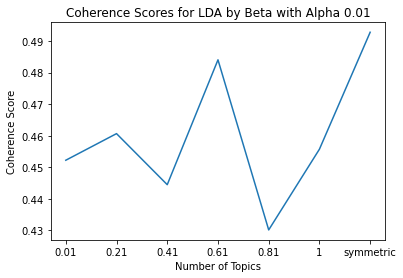

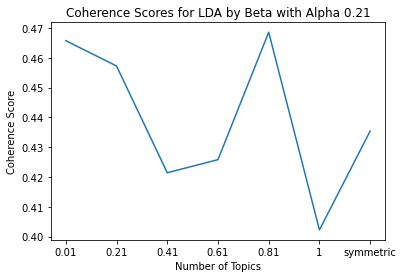

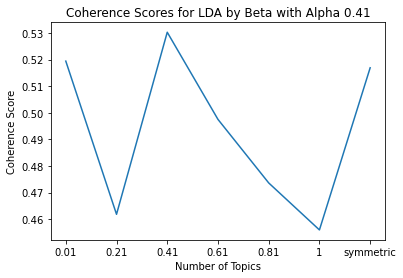

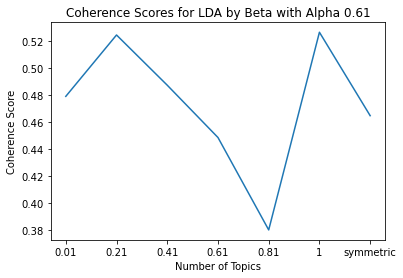

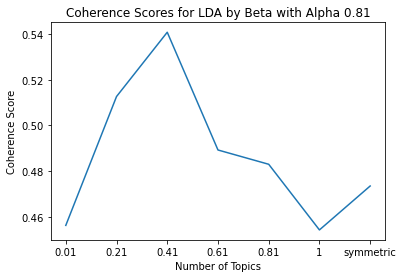

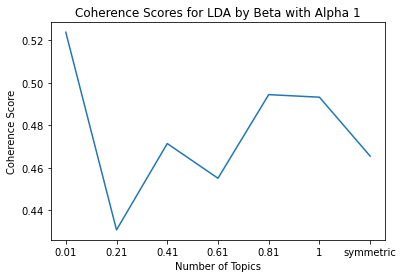

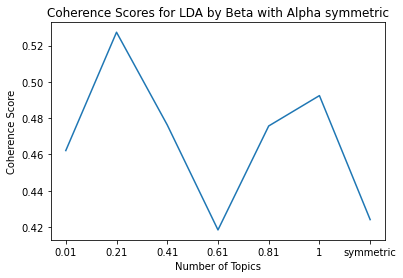

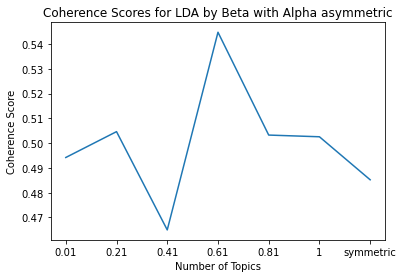

In [8]:
# Plot the results
for a, adf in dataframes.items():
    tm.graph_results(
        f'Coherence Scores for LDA by Beta with Alpha {a}',
        adf['beta'].tolist(),
        adf['coherence'].tolist()
    )

In [10]:
# Calculate additional information
max_result = overall_df[
    overall_df['coherence'] == max(overall_df['coherence'])]
best_coherence = float(max_result['coherence'])
best_alpha = max_result['alpha'].item()
best_beta = max_result['beta'].item()
best_model = max_result['model'].item()

print(f'Highest coherence score was {best_coherence} '
      f'using alpha {best_alpha} and beta {best_beta}')

Highest coherence score was 0.544720811804266 using alpha asymmetric and beta 0.61


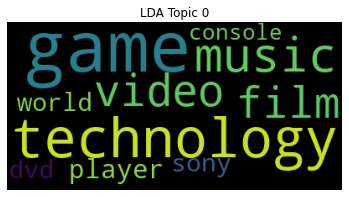

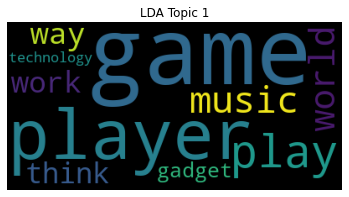

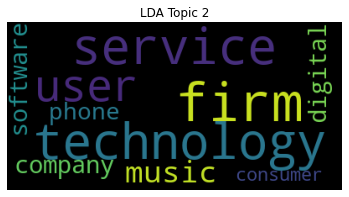

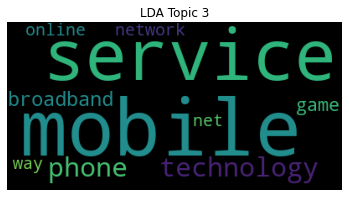

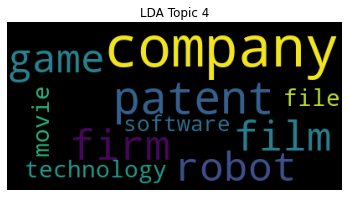

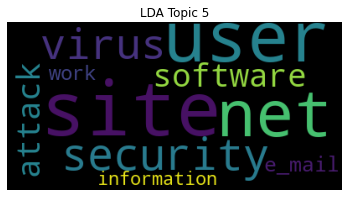

In [11]:
# Create wordclouds for final LDA
for i, topic in best_model.show_topics(formatted=False):
    tm.form_wordcloud(f'LDA Topic {i}', topic)

In [12]:
# Assign labels to topics if possible
labels = {}

for i, topic in best_model.show_topics(formatted=False, num_words=5):
    print(f'Final LDA Topic {i}: ', end='')
    print(' '.join([word for word, _ in topic]))
    label = input('\tEnter topic label: ')
    labels[i] = label
    print()

Final LDA Topic 0: game technology music video film


	Enter topic label:  entertainment



Final LDA Topic 1: game player play music world


	Enter topic label:  entertainment



Final LDA Topic 2: firm technology service user music


	Enter topic label:  business



Final LDA Topic 3: mobile service technology phone broadband


	Enter topic label:  technology



Final LDA Topic 4: company patent firm film robot


	Enter topic label:  business



Final LDA Topic 5: site user net security virus


	Enter topic label:  technology


In [13]:
# Perform quantitative analysis on qualitative results
total_unlabelled = len([s for _, s in labels.items() if not len(s)])
unlabelled_percent = round((total_unlabelled / len(labels)) * 100)
print(f'Total topics unlabelled for final LDA: {unlabelled_percent}%')

all_labels = set([s for _, s in labels.items() if s])
covered_labels = len([s for s in all_labels if s in tm.DEFAULT_LABELS])
covered_percent = round((covered_labels / len(tm.DEFAULT_LABELS)) * 100) 
print(f'Total label coverage for final LDA: {covered_percent}%')

Total topics unlabelled for final LDA: 0%
Total label coverage for final LDA: 60%
